In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("Environment ready 🚀")


Environment ready 🚀


In [6]:
np.random.seed(42)
n = 1000

data = pd.DataFrame({
    "age": np.random.randint(18, 80, n),
    "gender": np.random.choice(["Male", "Female"], n),
    "policy_type": np.random.choice(["Basic", "Premium", "Gold"], n),
    "sum_insured": np.random.choice([200000, 300000, 500000, 1000000], n),
    "disease_category": np.random.choice(["Cardiac", "Orthopedic", "Cancer", "General"], n),
    "hospital_type": np.random.choice(["Network", "Non-Network"], n),
    "length_of_stay": np.random.randint(1, 15, n),
    "claimed_amount": np.random.randint(10000, 500000, n),
    "previous_claims": np.random.randint(0, 5, n)
})

data["approved"] = (
    (data["claimed_amount"] < data["sum_insured"]) &
    (data["hospital_type"] == "Network")
).astype(int)

data["approved_amount"] = np.where(
    data["approved"] == 1,
    data["claimed_amount"] * np.random.uniform(0.7, 1.0, n),
    0
)



In [3]:
data.to_csv("../data/raw/medical_claims.csv", index=False)
print("Dataset saved to data/raw")


Dataset saved to data/raw


In [5]:
import pandas as pd

df = pd.read_csv("../data/raw/medical_claims.csv")
df.head()


,age,gender,policy_type,sum_insured,disease_category,hospital_type,length_of_stay,claimed_amount,previous_claims,approved,approved_amount
0,56,Male,Gold,200000,Cardiac,Network,12,463497,4,0,0.0
1,69,Male,Basic,300000,Cardiac,Non-Network,11,288404,4,0,0.0
2,46,Female,Gold,200000,Orthopedic,Non-Network,8,134997,0,0,0.0
3,32,Male,Basic,200000,General,Non-Network,10,307584,1,0,0.0
4,60,Male,Gold,300000,Orthopedic,Non-Network,7,367226,1,0,0.0


In [7]:
approval_rate = df["approved"].mean()
approval_rate


np.float64(0.394)

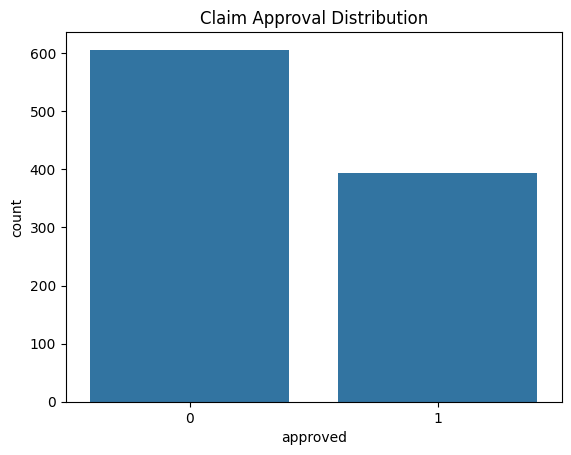

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x="approved", data=df)
plt.title("Claim Approval Distribution")
plt.show()


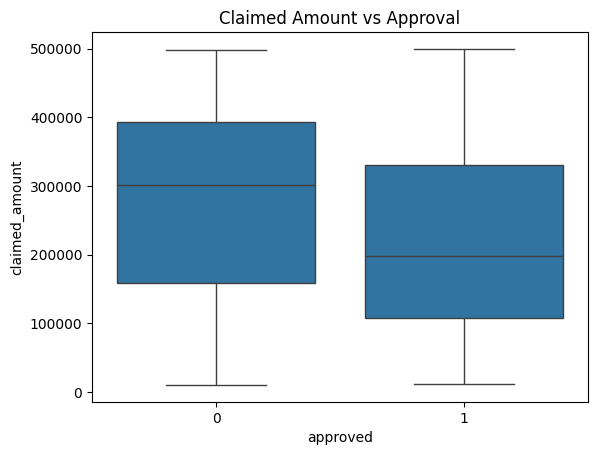

In [9]:
sns.boxplot(x="approved", y="claimed_amount", data=df)
plt.title("Claimed Amount vs Approval")
plt.show()


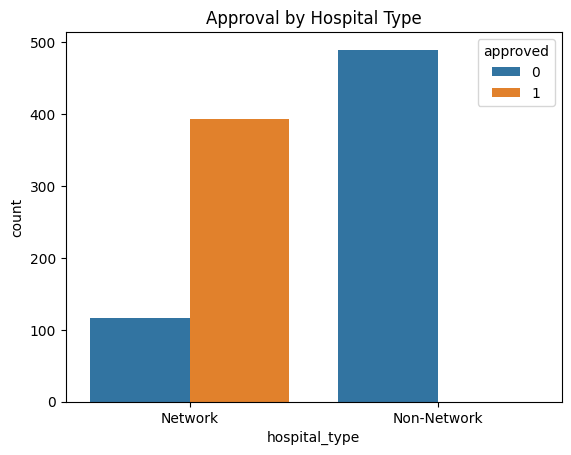

In [10]:
sns.countplot(x="hospital_type", hue="approved", data=df)
plt.title("Approval by Hospital Type")
plt.show()


### Key EDA Insights
- Claims from network hospitals have higher approval rates.
- Claims exceeding sum insured are mostly rejected.
- Approved claims have lower variance in claimed amount.



In [12]:
X = df.drop(columns=["approved", "approved_amount"])
y = df["approved"]
X = pd.get_dummies(X, drop_first=True)
X.head()


,age,sum_insured,length_of_stay,claimed_amount,previous_claims,gender_Male,policy_type_Gold,policy_type_Premium,disease_category_Cardiac,disease_category_General,disease_category_Orthopedic,hospital_type_Non-Network
0,56,200000,12,463497,4,True,True,False,True,False,False,False
1,69,300000,11,288404,4,True,False,False,True,False,False,True
2,46,200000,8,134997,0,False,True,False,False,False,True,True
3,32,200000,10,307584,1,True,False,False,False,True,False,True
4,60,300000,7,367226,1,True,True,False,False,False,True,True


In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


In [14]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
y_prob = lr.predict_proba(X_test)[:, 1]


In [15]:
from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       0.97      0.98      0.97       152
           1       0.97      0.95      0.96        98

    accuracy                           0.97       250
   macro avg       0.97      0.96      0.97       250
weighted avg       0.97      0.97      0.97       250

ROC-AUC: 0.9979189044038668


In [16]:
importance = pd.Series(lr.coef_[0], index=X.columns).sort_values(ascending=False)
importance.head(10)


gender_Male                 0.236180
disease_category_General    0.103373
previous_claims             0.019303
length_of_stay              0.015053
age                         0.010686
sum_insured                 0.000007
claimed_amount             -0.000010
policy_type_Premium        -0.046323
disease_category_Cardiac   -0.143520
policy_type_Gold           -0.212577
dtype: float64

In [17]:
approved_df = df[df["approved"] == 1].copy()
approved_df.shape


(394, 11)

In [18]:
X_amt = approved_df.drop(columns=["approved", "approved_amount"])
y_amt = approved_df["approved_amount"]
X_amt = pd.get_dummies(X_amt, drop_first=True)


In [19]:
from sklearn.model_selection import train_test_split

X_train_amt, X_test_amt, y_train_amt, y_test_amt = train_test_split(
    X_amt, y_amt, test_size=0.25, random_state=42
)


In [20]:
from sklearn.linear_model import LinearRegression

lr_amt = LinearRegression()
lr_amt.fit(X_train_amt, y_train_amt)

y_pred_amt = lr_amt.predict(X_test_amt)


In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test_amt, y_pred_amt)
rmse = np.sqrt(mean_squared_error(y_test_amt, y_pred_amt))

print("MAE:", mae)
print("RMSE:", rmse)


MAE: 15627.99821593658
RMSE: 20463.133561164323


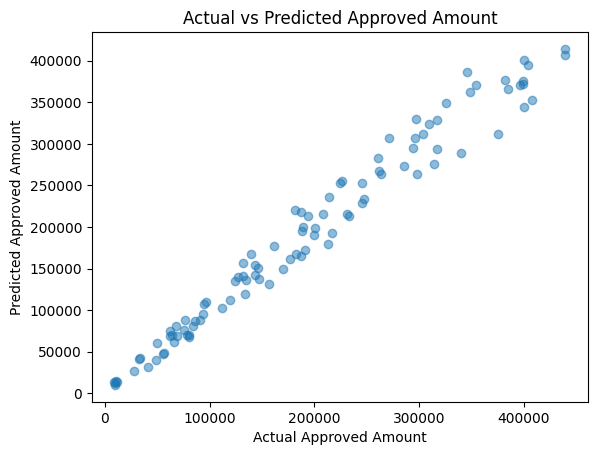

In [22]:
import matplotlib.pyplot as plt

plt.scatter(y_test_amt, y_pred_amt, alpha=0.5)
plt.xlabel("Actual Approved Amount")
plt.ylabel("Predicted Approved Amount")
plt.title("Actual vs Predicted Approved Amount")
plt.show()


In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced"
)

rf.fit(X_train, y_train)

rf_prob = rf.predict_proba(X_test)[:, 1]
print("Random Forest ROC-AUC:", roc_auc_score(y_test, rf_prob))


Random Forest ROC-AUC: 0.9998657357679914


In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np

rf_amt = RandomForestRegressor(
    n_estimators=200,
    random_state=42
)

rf_amt.fit(X_train_amt, y_train_amt)

y_pred_rf_amt = rf_amt.predict(X_test_amt)

print("RF MAE:", mean_absolute_error(y_test_amt, y_pred_rf_amt))


RF MAE: 16124.800540799983


In [27]:
import joblib

joblib.dump(rf, "../models/approval_model.pkl")
joblib.dump(rf_amt, "../models/amount_model.pkl")

print("Models saved successfully")


Models saved successfully
